This is a program which is in testing phase. We will use a linear regression ML model to give an SOC number for the flights.

In [1]:
# Import the querying module
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

In [2]:
all_data = pd.read_csv("ml_model_outputs/all_data.csv")

In [3]:
# Split the data into train and test sets
train_data, test_data = train_test_split(all_data, test_size=0.3, random_state=42)

In [4]:
print(f"Length train_x = {len(train_data)} \n Length train_y = {len(test_data)}")

Length train_x = 1215 
 Length train_y = 522


One-Hot-Encoding of the Operations columns

In [5]:
# ONE-HOT ENCODE
# https://stackabuse.com/one-hot-encoding-in-python-with-pandas-and-scikit-learn/
def one_hot(df, col, pre):
  encoded = pd.get_dummies(df[col], prefix=pre)
  for column in encoded:
    encoded = encoded.rename(columns={column: col + "_" + column})
  encoded['unique_data_identifier'] = df['unique_data_identifier']
  return encoded

In [6]:
# Encode Train data
train_encoded = one_hot(train_data, "activity", 'is')
final_train_x = pd.merge(train_data, train_encoded, on=["unique_data_identifier"])
final_train_y = final_train_x["soc_delta"].to_numpy()
final_train_x = final_train_x.drop(columns=["soc_delta", "id", "unique_data_identifier", "activity", "Unnamed: 0"])

# Encode Test data
test_encoded = one_hot(test_data, "activity", 'is')
final_test_x = pd.merge(test_data, test_encoded, on=["unique_data_identifier"])
final_test_y = final_test_x["soc_delta"].to_numpy()
final_test_x = final_test_x.drop(columns=["soc_delta", "id", "unique_data_identifier", "activity", "Unnamed: 0"])

In [7]:
print(f"Length test_encoded = {len(test_encoded)} \n Length train_encoded = {len(train_encoded)}")

Length test_encoded = 522 
 Length train_encoded = 1215


In [8]:
print(f"Length train_x = {len(final_train_x)} \n Length train_y = {len(final_train_y)}")

Length train_x = 1215 
 Length train_y = 1215


In [9]:
print(f"Length test_x = {len(final_test_x)} \n Length test_y = {len(final_test_y)}")

Length test_x = 522 
 Length test_y = 522


In [10]:
print(final_train_y)

[0.  0.  3.5 ... 5.  0.  2.5]


Machine Learning Model Implementation

In [11]:
print("Unique classes in final_train_y:", np.unique(final_train_y))

Unique classes in final_train_y: [ 0.    0.04  0.12  0.17  0.21  0.25  0.29  0.38  0.46  0.5   0.55  0.58
  0.62  0.68  0.71  0.82  0.86  0.88  0.92  0.95  0.96  1.    1.04  1.08
  1.21  1.29  1.3   1.5   1.54  1.71  1.79  1.86  1.88  1.96  2.    2.12
  2.21  2.25  2.33  2.38  2.42  2.46  2.5   2.54  2.58  2.62  2.83  2.88
  2.96  3.    3.04  3.05  3.12  3.17  3.29  3.32  3.5   3.58  3.67  3.79
  3.88  3.92  3.96  4.    4.04  4.29  4.38  4.5   4.54  4.71  4.79  4.88
  4.96  5.    5.04  5.29  5.38  5.5   6.    6.12  6.5   6.54  7.    7.12
  7.5   8.    8.12  8.21  8.5   8.71  8.79  9.    9.12  9.21  9.5   9.54
 10.   10.04 10.29 10.5  11.   11.5  11.62 12.   13.   14.   16.62 17.5
 18.   24.   24.25 28.   31.21 31.5  35.5  36.  ]


In [12]:
# Replace "28" with "11"
final_train_y_replaced = np.where(final_train_y == 28, 11, final_train_y)

# Print the updated unique classes
print("Unique classes in final_train_y (after replacing '28' with '11'):", np.unique(final_train_y_replaced))

Unique classes in final_train_y (after replacing '28' with '11'): [ 0.    0.04  0.12  0.17  0.21  0.25  0.29  0.38  0.46  0.5   0.55  0.58
  0.62  0.68  0.71  0.82  0.86  0.88  0.92  0.95  0.96  1.    1.04  1.08
  1.21  1.29  1.3   1.5   1.54  1.71  1.79  1.86  1.88  1.96  2.    2.12
  2.21  2.25  2.33  2.38  2.42  2.46  2.5   2.54  2.58  2.62  2.83  2.88
  2.96  3.    3.04  3.05  3.12  3.17  3.29  3.32  3.5   3.58  3.67  3.79
  3.88  3.92  3.96  4.    4.04  4.29  4.38  4.5   4.54  4.71  4.79  4.88
  4.96  5.    5.04  5.29  5.38  5.5   6.    6.12  6.5   6.54  7.    7.12
  7.5   8.    8.12  8.21  8.5   8.71  8.79  9.    9.12  9.21  9.5   9.54
 10.   10.04 10.29 10.5  11.   11.5  11.62 12.   13.   14.   16.62 17.5
 18.   24.   24.25 31.21 31.5  35.5  36.  ]


In [13]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Create an XGBoost Regressor
xgb_model = XGBRegressor(n_estimators=100, random_state=30, max_depth=3, learning_rate=0.45)

# Train the model on the training data
xgb_model.fit(final_train_x, final_train_y_replaced)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.45, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=30, ...)

In [14]:
# if there is no power on stall activities in test set, add the column with all false values
if 'activity_is_power on stall' not in final_test_x.columns:
  final_test_x.insert(loc=final_test_x.columns.get_loc('activity_is_slow flight'), column='activity_is_power on stall', value=False)

In [15]:
# Make predictions on the test data
y_pred = xgb_model.predict(final_test_x)

In [16]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_error

# Mean Squared Error (MSE)
mse = mean_squared_error(final_test_y, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

# Coefficient of Determination (R-squared)
r_squared = r2_score(final_test_y, y_pred)
print(f'Coefficient of Determination (R-squared): {r_squared}')

# K-fold Cross-Validation for R-squared
cross_val_r_squared = cross_val_score(xgb_model, final_train_x, final_train_y, cv=5, scoring='r2')
print(f'Cross-validated R-squared: {np.mean(cross_val_r_squared)}')

# Mean Absolute Error (MAE)
mae = mean_absolute_error(final_test_y, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(final_test_y, y_pred))
print(f'Root Mean Squared Error (RMSE): {rmse}')

from sklearn.model_selection import cross_val_score, KFold

# Define the number of folds (k)
num_folds = 5  # You can adjust this based on your preference

# Create a KFold object
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation for R-squared
cross_val_r_squared = cross_val_score(xgb_model, final_train_x, final_train_y, cv=kf, scoring='r2')

# Display the results
print(f'K-fold Cross-validated R-squared: {np.mean(cross_val_r_squared)}')


Mean Squared Error (MSE): 2.0215527574024432
Coefficient of Determination (R-squared): 0.8925439718537183
Cross-validated R-squared: 0.877938964640158
Mean Absolute Error (MAE): 0.5753275057925019
Root Mean Squared Error (RMSE): 1.4218131935674403
K-fold Cross-validated R-squared: 0.8795089563440225


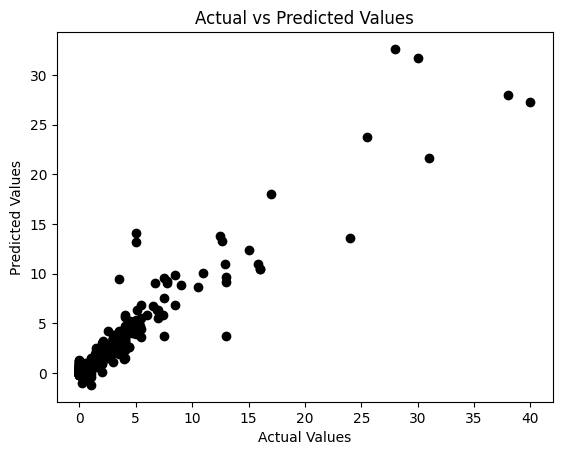

In [17]:
import matplotlib.pyplot as plt

# Plot outputs
plt.scatter(final_test_y, y_pred, color="black")

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")

plt.show()

Feature Importances:
                        Feature  Importance
8             activity_is_climb    0.431218
16          activity_is_takeoff    0.188001
9            activity_is_cruise    0.152879
0                    time_delta    0.109067
2              average_altitude    0.063899
4                 average_power    0.031935
11          activity_is_landing    0.007722
5                   temperature    0.003690
1                           soh    0.003635
3                  ground_speed    0.003329
7                    wind_speed    0.001649
15      activity_is_steep turns    0.001115
6                    visibility    0.000654
14      activity_is_slow flight    0.000549
10          activity_is_descent    0.000363
12  activity_is_power off stall    0.000157
13   activity_is_power on stall    0.000138


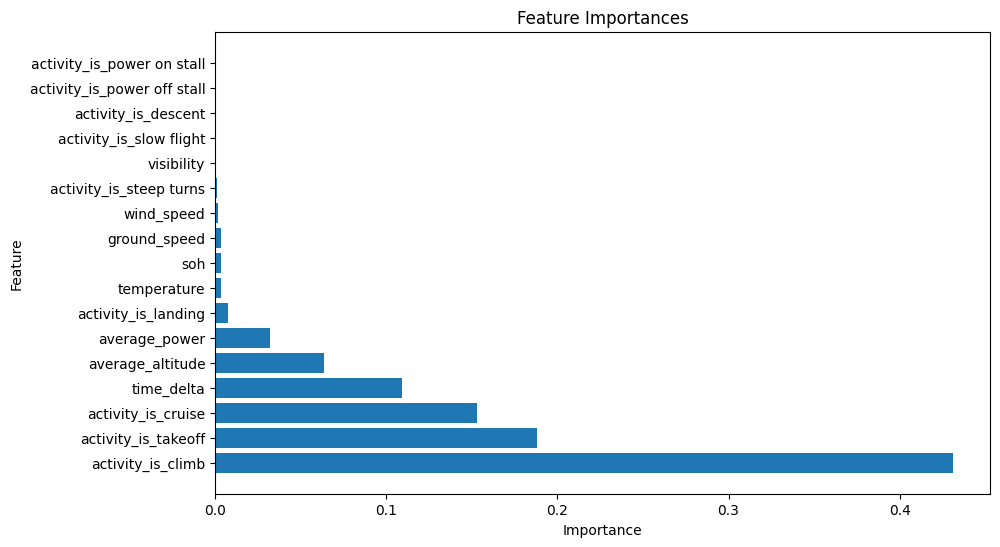

In [18]:
# Get feature importances
feature_importances = xgb_model.feature_importances_

# Get the corresponding feature names
feature_names = final_train_x.columns

# Create a DataFrame to display feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print("Feature Importances:")
print(feature_importance_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

In [19]:
import joblib

model_filename = 'ML_model_outputs/prescription_xgboost_model.joblib'
joblib.dump(xgb_model, model_filename)

print(f"Model saved to {model_filename}")

Model saved to ML_model_outputs/prescription_xgboost_model.joblib
